# First Assignment
## MSc course in Artificial Intelligence



In [1]:
# Initially, we clone the course repository
# !rm -rf AI_USI_MA
# !git clone https://github.com/UmbertoJr/AI_USI_MA.git

In [2]:
# Let's prepare the environment by importing necessary libraries.
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from time import time as t
import matplotlib.pyplot as plt

################################################
# Depending on your execution environment, the way you import the required module will differ.

# If you are running this script locally on your machine, use the following import:
# from IO_manager.io_tsp import TSP_Instance_Creator
# from solvers.local_search import TwoOpt
# from solvers.TSP_solver import Solver_TSP
# from solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
# from solvers.constructive_algorithms import compute_length
# from solvers.local_search import TwoOpt
# from solvers.two_opt_with_candidate import twoOpt_with_cl

# However, if you are executing this notebook within Google Colab and the libraries are stored
# in a folder named 'AI_USI_MA', you should use the import statement below:
from AI_USI_MA.IO_manager.io_tsp import TSP_Instance_Creator
from AI_USI_MA.solvers.local_search import TwoOpt
from AI_USI_MA.solvers.TSP_solver import Solver_TSP
from AI_USI_MA.solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
from AI_USI_MA.solvers.constructive_algorithms import compute_length
from AI_USI_MA.solvers.local_search import TwoOpt
from AI_USI_MA.solvers.two_opt_with_candidate import twoOpt_with_cl




---
## Iterated Local Search (ILS) for the Traveling Salesman Problem (TSP)

The Iterated Local Search (ILS) is a metaheuristic that seeks to improve the quality of solutions by repeatedly applying a local search and introducing slight modifications (perturbations) to escape from local optima. This approach proves beneficial, especially for combinatorial problems like the Traveling Salesman Problem (TSP).

In this assignment, we will be focusing on solving the TSP using ILS for three benchmark instances:

1. **d198**: A standard instance known as 'd198.tsp' in TSP literature.
2. **pr439**: Another well-studied instance that will test the efficiency and efficacy of our ILS approach.
3. **u1060**: A relatively larger instance, serving as a comprehensive test for the scalability of our method.

Let's begin by loading and inspecting the 'd198.tsp' instance.


name: d198
nPoints: 198
best_sol: 15780.0


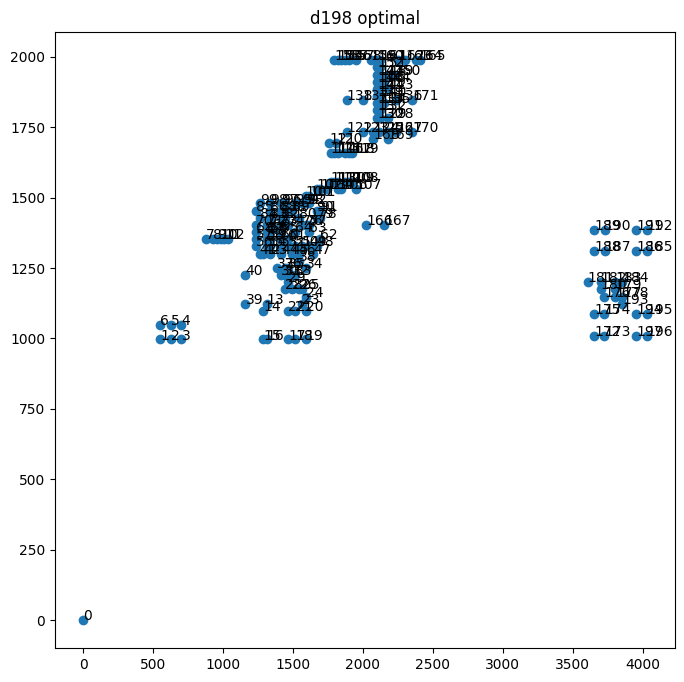

In [3]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

---
## 2-opt Algorithm for TSP

The 2-opt algorithm is a renowned local search method, predominantly utilized for refining solutions in the Traveling Salesman Problem (TSP). At its core, the algorithm takes a route and systematically swaps pairs of cities to ascertain if the change results in a shorter tour.

In this notebook, we furnish a black-box version of the 2-opt. For those embarking on its usage for the first time, we suggest revisiting our ["Introduction to the TSP"](https://colab.research.google.com/github/UmbertoJr/AI_USI_MA/blob/master/introduction_to_the_TSP.ipynb#scrollTo=4aGR4Nus83wa). It's paramount that any meta-heuristic, including 2-opt, complies with the specific input and output conventions laid out in the primary notebook.

For a tangible example, glance over the **naive_heuristic**. Within, the `TwoOpt.local_search` method is invoked to iteratively enhance the TSP solution.

Two instrumental aspects to note in our design are:
1. The `yield` statement: Serving as a generator, it permits the algorithm to produce solutions in phases, thus allowing exploration of a plethora of potential solutions without exhaustive execution.
2. The `ending_cond` (Ending Condition): Crafted to ensure the TSP Solver either ceases after 3 minutes or concludes when the local search achieves an optimum state via the heuristic.

---


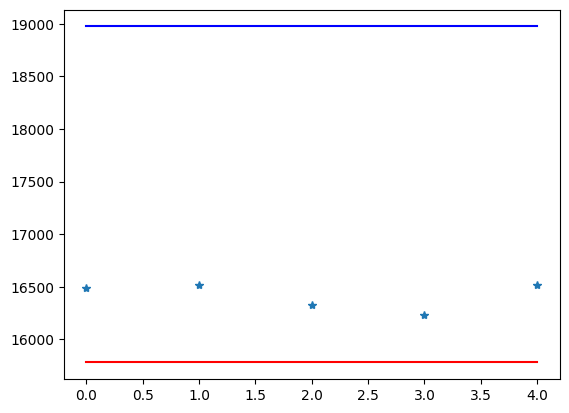

best gap with NN 20.25% on 1 trial,
with a total time of 0.003 seconds

best gap with random + 2opt 2.86% on 5 trials,
with a total time of 3.0 seconds


In [4]:
def naive_heuristic(solution, cost_sol, dist_matrix):
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix):
    new_solution, new_cost, number_calls_ls, ending_cond = data
    yield  new_solution, new_cost, number_calls_ls, ending_cond

number_of_trials = 5
found_lens = []
start = t()
solver = Solver_TSP(('random', Random_Initializer.random_method))
solver.bind(('naive heuristic', naive_heuristic ))

for _ in range(number_of_trials):
  solver(ic)
  found_lens.append(solver.found_length)
end = t()

solver = Solver_TSP(('nearest neighbor', Nearest_Neighbor.nn))
solver(ic)

plt.plot(found_lens, "*")
plt.plot(np.ones(number_of_trials)*ic.best_sol, "r-")
plt.plot(np.ones(number_of_trials)*solver.found_length, "b-")
plt.show()
print(f"best gap with NN {solver.gap}% on 1 trial,\nwith a total time of {np.round(solver.time_to_solve, 5)} seconds")
print()
print(f"best gap with random + 2opt {np.round(100*(min(found_lens) - ic.best_sol)/ic.best_sol, 2)}% on {number_of_trials} trials,\nwith a total time of {np.round(end - start, 2)} seconds")

## Double Bridge

Here you need to implement your own Double Bridge permutation!

In [5]:
class DoubleBridge:
  @staticmethod
  def difference_cost(solution, a, b, c, d, matrix):
    #subtract the cost of the removed edges
    change_cost=-matrix[solution[a-1],solution[a]]
    change_cost-=matrix[solution[b-1],solution[b]]
    change_cost-=matrix[solution[c-1],solution[c]]
    change_cost-=matrix[solution[d-1],solution[d]]

    # add the cost of the inserted edges
    change_cost+=matrix[solution[a-1],solution[c]]
    change_cost+=matrix[solution[d-1],solution[b]]
    change_cost+=matrix[solution[c-1],solution[a]]
    change_cost+=matrix[solution[b-1],solution[d]]

    return change_cost

  @staticmethod
  def perturb_solution(solution, actual_cost, matrix):

    # random sample 4 edges without replacement and sort them
    a,b,c,d=np.sort(np.random.choice( list(range(1,len(solution))), 4, replace=False))

    print("Random sampled edges: ",a,b,c,d)

    # compute the difference in cost following the double bridge move
    change_cost=DoubleBridge.difference_cost(solution, a, b,c ,d, matrix)
    actual_cost+=change_cost


    # print(solution[:a],solution[c:d],solution[b:c],solution[a:b],solution[d:])
    solution = np.concatenate([solution[:a], solution[c:d], solution[b:c],
                               solution[a:b], solution[d:]])

    return solution, actual_cost

In [109]:
# example perturbation
case_solution = np.arange(12)
matrix = np.random.rand(12, 12)
cost = compute_length(case_solution, matrix)
print(case_solution, cost)

new_sol, new_length = DoubleBridge.perturb_solution(case_solution, cost, matrix)
print(new_sol, new_length)

print("\n")
# to check that difference_cost works as expected, I did a quick test comparing the 
# result of compute_length(new_sol, matrix) and new_length

print("len computed with compute_lenth function: ",compute_length(new_sol, matrix),
      "\n",
      "len computed by adding the cost difference to the previous cost: ",new_length)

[ 0  1  2  3  4  5  6  7  8  9 10 11] 5.311367930531917
Random sampled edges:  6 7 10 11
[ 0  1  2  3  4  5 10  7  8  9  6 11] 4.727320306743326


len computed with compute_lenth function:  4.727320306743326 
 len computed by adding the cost difference to the previous cost:  4.727320306743326


## Iterated Local Search


Here you need to implement the three variants of the ILS we saw earlier in class.

To boost the time performances please use the cython class **two_opt_with_candidate**.

In [15]:
def my_local_search(solution, cost_sol, dist_matrix):
  new_solution, new_cost = solution, cost_sol
  # function local_search from local_search.py
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix):
    new_solution, new_cost, number_calls_ls, ending_cond = data
    if ending_cond == True:
      break
  return new_solution, new_cost

def generate_cl(dist_matrix):
  n = dist_matrix.shape[0]
  # cl = np.zeros((n, 100))
  cl = np.zeros((n, 20))
  for i in range(n):
    cl[i] = np.argsort(dist_matrix[i, :])[1: 21]
  return cl

class ILS_Better:
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_better
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    """
    #  in case you want to use twoOpt_with_cl
    cl = generate_cl(matrix) # remember you don't need to compute the cl each time
    new_sol, new_cost = twoOpt_with_cl(solution, actual_cost, matrix, cl)
    """
    best_sol,best_cost = new_sol, new_cost
    cost_sol_better.append(new_cost)
    ls_calls = 1
    while True:
      # implement perturbation
      pert_sol, pert_length = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)
      # local_search
      new_sol, new_cost = my_local_search(pert_sol, pert_length, matrix)

      # implement acceptance criterion
      # if new_cost is better than best_cost
      # set best_cost=new_cost and best_sol=new_sol
      if(new_cost<best_cost):
        best_sol=new_sol
        best_cost=new_cost
        cost_sol_better.append(best_cost)

      ls_calls+=1
      yield best_sol, best_cost, ls_calls, False

class ILS_RW:
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_RW
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_RW.append(new_cost)
    ls_calls = 1
    while True:
      # implement perturbation
      pert_sol, pert_length = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)
      
     # implement acceptance criterion 
     # accept any new solution irrespective of its quality.
      best_sol, best_cost = my_local_search(pert_sol, pert_length, matrix)
      cost_sol_RW.append(best_cost)
      ls_calls+=1
      yield best_sol, best_cost, ls_calls, False

class ILS_LSMC:
  @staticmethod
  def acceptance_criterion(best_cost, new_cost, temperature):
    # if new cost smaller than best cost, execute the move
    if(new_cost<best_cost):
      return True

    # else if new_cost>best_cost and
    # np.exp((best_cost-new_cost)/temperature)>np.random.uniform(0,1,size=1)
    # then execute the move
    else:
      if(np.exp((best_cost-new_cost)/temperature)>np.random.uniform(0,1,size=1)):
        return True

    # else no change
    return False

  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_LSMC
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_LSMC.append(new_cost)
    ls_calls = 1

    temperature=1000
    while True:
      # implement perturbation
      pert_sol, pert_length = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)

      # local_search
      new_sol, new_cost = my_local_search(pert_sol, pert_length, matrix)

      # implement acceptance criterion
      #call  the ILS_LSMC.acceptance_criterion from above 
      if(ILS_LSMC.acceptance_criterion(best_cost, new_cost, temperature)):
        best_sol=new_sol
        best_cost=new_cost

        cost_sol_LSMC.append(best_cost)


      ls_calls+=1
      temperature=temperature*0.85
      print(temperature)
      yield best_sol, best_cost, ls_calls, False

### Example of Table

Take care that you need to change the code in order to satisfy the requirements for the task!

In [16]:
seeds= [0, 123, 333]
time_to_solve = 180 # in seconds

cost_sol_better = []
cost_sol_RW = []
cost_sol_LSMC = []

names_instances = ["pr439.tsp"] #, "d198.tsp", "pr439.tsp", "u1060.tsp"

initializers = ["random"]
init_functions = [Random_Initializer.random_method]

improvements = ["ILS-better","ILS-RW","ILS-LSMC"]
improve_functions = [ILS_Better.solve, ILS_RW.solve, ILS_LSMC.solve]

results = []
index = []
samples = {name: {improve: {seed: [] for seed in seeds} for improve in improvements} for name in names_instances}

for s_ in seeds:
  collectors = [cost_sol_better, cost_sol_RW, cost_sol_LSMC]
  for i, init in enumerate(initializers):
    for j, improve in enumerate(improvements):
      solver = Solver_TSP((init, init_functions[i]), seed_=s_, stop_run_after=time_to_solve)
      solver.bind((improve, improve_functions[j]))
      for name in names_instances:
        instance = TSP_Instance_Creator("standard", name)
        solver(instance)
        index.append((name, instance.best_sol, solver.name_method, s_))
        results.append([solver.found_length, solver.gap, solver.time_to_solve, solver.ls_calls])
        samples[name][improve][s_] = np.round(np.abs(np.array(collectors[j]) - instance.best_sol)/instance.best_sol * 100, 2)
        if j == 0:
          cost_sol_better = []
        elif j == 1:
          cost_sol_RW = []
        else:
          cost_sol_LSMC = []

index = pd.MultiIndex.from_tuples(index, names=['problem','optimal length', 'method', 'seed'])

pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls Local Search"])

Random sampled edges:  63 278 279 362
Random sampled edges:  15 44 356 430
Random sampled edges:  73 115 249 300
Random sampled edges:  91 193 207 325
Random sampled edges:  36 62 367 400
Random sampled edges:  6 125 233 343
Random sampled edges:  4 72 217 324
Random sampled edges:  141 147 170 340
Random sampled edges:  21 22 111 179
Random sampled edges:  180 190 243 274
Random sampled edges:  58 74 181 365
Random sampled edges:  1 97 223 383
Random sampled edges:  23 39 185 358
Random sampled edges:  105 160 277 336
Random sampled edges:  96 265 278 389
Random sampled edges:  144 157 420 438
Random sampled edges:  3 129 358 422
Random sampled edges:  124 243 311 413
Random sampled edges:  4 66 177 216
Random sampled edges:  99 158 314 365
Random sampled edges:  29 114 118 241
Random sampled edges:  80 110 212 370
Random sampled edges:  12 147 385 404
Random sampled edges:  41 68 311 355
Random sampled edges:  83 88 200 374
Random sampled edges:  59 192 218 346
Random sampled edges: 

tour length  \
problem   optimal length method                                            seed                
pr439.tsp 107217.0       initialized with random, improved with ILS-better 0        109170.0   
                         initialized with random, improved with ILS-RW     0        115545.0   
                         initialized with random, improved with ILS-LSMC   0        109358.0   
                         initialized with random, improved with ILS-better 123      111524.0   
                         initialized with random, improved with ILS-RW     123      115681.0   
                         initialized with random, improved with ILS-LSMC   123      108935.0   
                         initialized with random, improved with ILS-better 333      111642.0   
                         initialized with random, improved with ILS-RW     333      112265.0   
                         initialized with random, improved with ILS-LSMC   333      110990.0   

                                                                                  gap  \
problem   optimal length method                                            seed         
pr439.tsp 107217.0       initialized with random, improved with ILS-better 0     1.82   
                         initialized with random, improved with ILS-RW     0     7.77   
                         initialized with random, improved with ILS-LSMC   0     2.00   
                         initialized with random, improved with ILS-better 123   4.02   
                         initialized with random, improved with ILS-RW     123   7.89   
                         initialized with random, improved with ILS-LSMC   123   1.60   
                         initialized with random, improved with ILS-better 333   4.13   
                         initialized with random, improved with ILS-RW     333   4.71   
                         initialized with random, improved with ILS-LSMC   333   3.52   

                                                                                 time to solve  \
problem   optimal length method                                            seed                  
pr439.tsp 107217.0       initialized with random, improved with ILS-better 0           181.069   
                         initialized with random, improved with ILS-RW     0           181.217   
                         initialized with random, improved with ILS-LSMC   0           181.068   
                         initialized with random, improved with ILS-better 123         181.372   
                         initialized with random, improved with ILS-RW     123         180.871   
                         initialized with random, improved with ILS-LSMC   123         180.516   
                         initialized with random, improved with ILS-better 333         180.431   
                         initialized with random, improved with ILS-RW     333         181.525   
                         initialized with random, improved with ILS-LSMC   333         180.140   

                                                                                 calls Local Search  
problem   optimal length method                                            seed                      
pr439.tsp 107217.0       initialized with random, improved with ILS-better 0                     84  
                         initialized with random, improved with ILS-RW     0                     82  
                         initialized with random, improved with ILS-LSMC   0                     87  
                         initialized with random, improved with ILS-better 123                   85  
                         initialized with random, improved with ILS-RW     123                   83  
                         initialized with random, improved with ILS-LSMC   123                   87  
                         initialized with random, improved with ILS-better 333                   85  
                         initialized with rando

ILS-better 
      0      123    333
0   9.07  10.06  13.21
1   8.30   9.59  11.80
2   8.00   9.29  10.04
3   7.09   9.08   9.46
4   6.50   8.65   9.38
5   5.92   7.37   9.16
6   5.40   6.47   5.05
7   5.31   4.74   5.00
8   4.49   4.43   4.74
9   3.57   4.02   4.34
10  3.06    NaN   4.14
11  2.32    NaN   4.13
12  1.82    NaN    NaN
0      5.4500
123    7.3700
333    7.5375
dtype: float64
ILS-RW 
      0      123    333
0   6.64  10.06  13.21
1   6.13   9.59  11.80
2   7.74   9.29  10.04
3   9.01   9.08   9.46
4   7.28   9.90  11.33
..   ...    ...    ...
80  8.88   7.95  10.45
81  7.77   8.62   7.41
82   NaN   7.89   9.87
83   NaN    NaN   5.58
84   NaN    NaN   4.71

[85 rows x 3 columns]
0      9.023049
123    9.575422
333    9.987882
dtype: float64
ILS-LSMC 
       0      123    333
0   12.08  10.06  13.21
1   10.75   9.59  11.80
2    8.09   9.29  10.04
3    7.40   9.08   9.46
4    7.65   9.90   9.28
5    6.65   9.61   9.10
6    5.91   6.20   7.97
7    5.90   4.44   7.57
8    5.84 

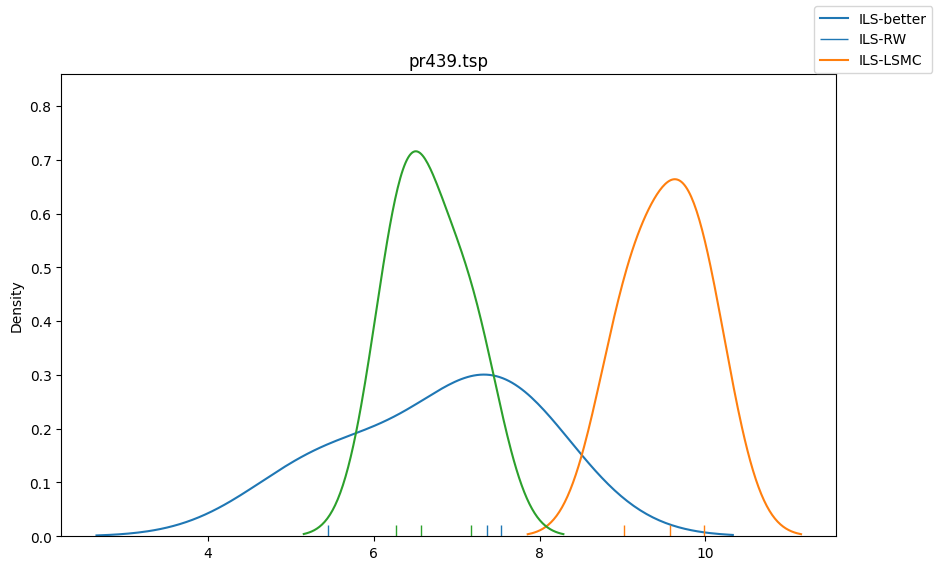

In [17]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  for instance in names_instances:
    fig = plt.figure(figsize=(10,6))
    for j, improve in enumerate(improvements):
      data = pd.DataFrame.from_dict(samples[instance][improve], orient='index').transpose()
      print(improve,'\n',data)
      data_avg = data.mean(axis = 0, skipna = True)
      print(data_avg)
      sns.distplot(data_avg, rug=True, hist=False)

    fig.legend(labels=improvements)
    plt.title(instance)
    plt.show()